<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/makeclassification_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset created using sklearn's `make_classification()`


In [ ]:
# Last amended: 7th June, 2023

## Basics

In [1]:
%reset -f

In [2]:
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 49.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.3 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=c1d324176c0c9cc475a63ab0f92e64fbeff92baaf78a295c86f0e7f94587eeef
  Stored in directory: /root/.cache/pip/wheels/49/27/15/dcf90953e3e3322e6f3e447514b20cf39b53c6518cb4a7bace
Successfully built python-igraph


In [3]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns


# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


In [4]:
# 1.05 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Generate data

In [5]:
# 1.1 Generate data with sklearn's make_blobs()

X, y = make_classification(n_samples=20000,
                           n_features=10,
                           n_informative=5,
                           n_classes=2,
                           n_clusters_per_class=2,
                           scale = 30
                           )


In [6]:
# 1.2 Transform it to a DataFrame:

data = pd.DataFrame(X, columns = list('abcdefghij'))
data['target'] = y

In [7]:
# 2.1
data.head()

,a,b,c,d,e,f,g,h,i,j,target
0,29.727154,-54.008351,34.687970,53.918336,83.852407,59.734429,15.902526,-41.630054,44.393627,140.073331,0
1,-17.647823,12.816261,-22.572154,-80.451537,20.605485,-139.559418,-55.116470,26.946995,-9.897706,-85.797668,1
2,27.210627,64.938320,13.254587,68.171993,34.961813,37.988106,22.378175,52.605780,51.745144,104.516003,0
3,3.463182,-70.573961,-36.373466,-0.806278,16.622269,-118.978564,-18.472191,1.982153,22.204519,-9.935607,0
4,-16.232278,-34.585133,0.923303,-39.410862,-5.532619,-84.034111,-83.134386,-46.390160,-4.200189,-67.045248,1


In [8]:
# 2.2 Proportions of three classes:

data['target'].value_counts(normalize = True)

1    0.50055
0    0.49945
Name: target, dtype: float64

In [9]:
# 2.3 Check nulls and any need for imputing?

data.isnull().sum().sum()

# 2.4
data.describe()

0

,a,b,c,d,e,f,g,h,i,j,target
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-1.743761,-0.354779,-0.158117,-15.284475,14.823262,-0.150167,-15.196904,0.063819,0.038132,-1.614269,0.500550
std,15.779356,29.864914,30.135622,45.044072,47.526005,53.192749,42.326274,29.909864,48.558360,63.365715,0.500012
min,-54.275857,-122.031546,-121.549294,-186.318150,-205.115686,-218.527694,-250.134980,-121.120493,-221.770038,-238.842043,0.000000
25%,-12.974031,-20.436170,-20.492994,-47.313351,-15.634571,-36.620148,-45.236348,-20.002466,-32.502617,-40.572110,0.000000
50%,-3.538823,-0.583607,-0.034900,-14.848488,17.277419,2.474544,-15.144183,0.216253,3.303873,-2.484417,1.000000
75%,10.229787,19.691752,19.864731,17.405070,47.219929,37.761368,18.412600,20.006001,34.920837,37.010918,1.000000
max,54.228277,149.233140,122.402048,138.427158,220.757203,242.292930,147.646381,124.986207,178.138968,262.357940,1.000000


## Histograms and boxplots of columns:

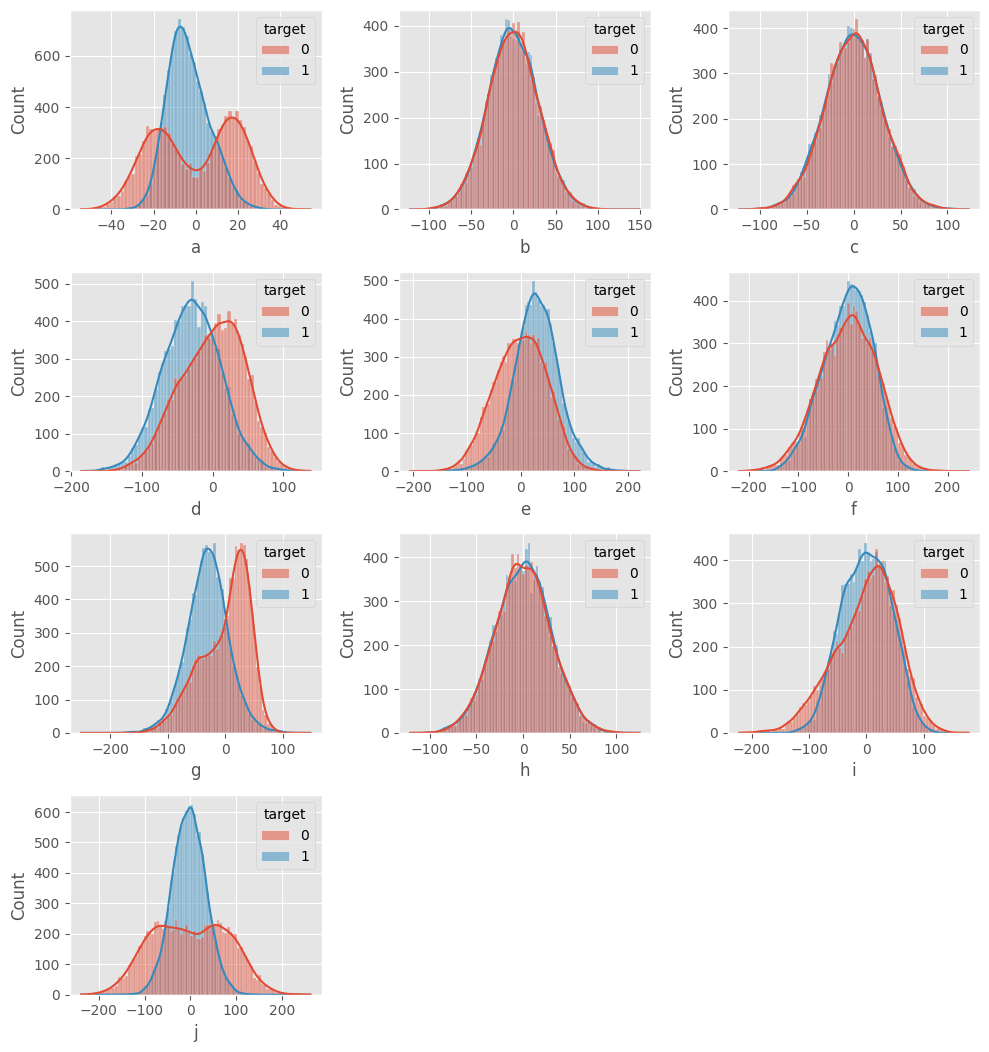

In [27]:
# 2.5 Lets look at the distribution plot of the features:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

#plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(10,18));
for i in data.columns[:-1]:      # exclude target
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=sns.histplot(data = data, x = i,ax=ax, hue = 'target', kde = 'True');
    plt.tight_layout();

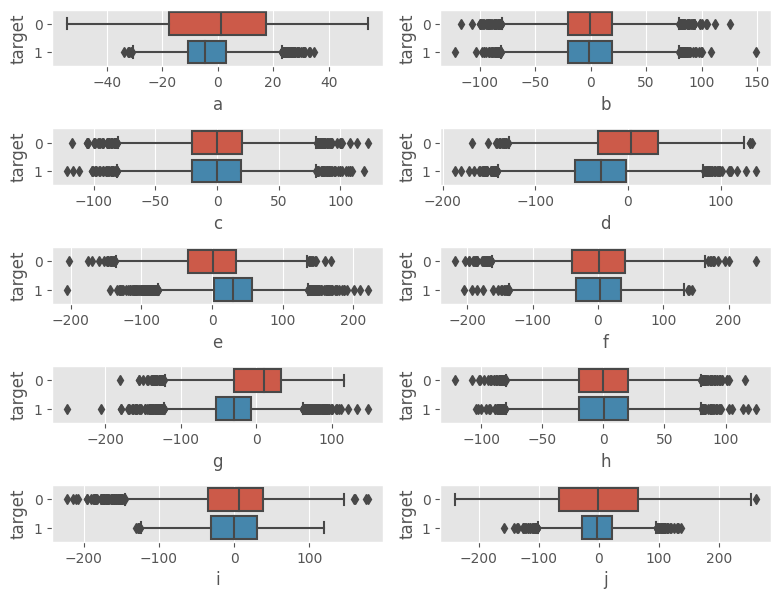

In [11]:
# 2.6 Lets look at relationship of features with target:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

df = data.copy()
df['target'] = df['target'].astype('string')
plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in df.columns[:-1]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.boxplot(data=df, x=i, y='target')
    plt.tight_layout();

del(df)    

In [25]:
best_features = ['a', 'd','e', 'g','i', 'j']

## Transform numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily` class.  

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand. 

In [ ]:
# 3.0 Discretise all features of data. And also split dataset.
#     into train/test:

_=data.pop('target')

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                                 y,
                                                                                 bins = 100,
                                                                                 test_size = 0.1,
                                                                                 genColName = False  # Keep orig col names
                                                                                )

In [ ]:
# 3.0.1 Check  original data:
#       It has target col also:

orig_train.shape     # (18000, 11)
print("\n======\n")  
orig_train.head(3)
orig_test.head(3)


(18000, 11)

,a,b,c,d,e,f,g,h,i,j,target
12853,-60.995882,-34.534492,-44.934785,-31.674756,-27.009274,24.327518,11.429454,-28.125479,-12.105154,13.770142,1
11901,-41.918758,13.830869,24.164114,-16.375734,12.830257,-3.272089,-32.129451,-20.541189,6.411539,2.161415,1
9937,-48.970867,31.491605,-0.999383,-10.111418,-2.600713,51.473495,3.704005,28.871546,-4.071868,-23.649124,1


,a,b,c,d,e,f,g,h,i,j,target
2098,-26.867268,15.126896,-28.221551,-5.813874,36.950213,15.743980,-33.286578,19.920941,6.309505,32.599329,1
17722,-54.343355,-28.151707,-7.131926,55.798094,-3.222504,4.414725,-71.294401,14.055026,23.817938,6.597556,0
5567,12.504865,-23.504547,-29.383594,-12.011778,-14.241396,-1.121158,39.553706,-30.595728,-46.108229,-21.959544,1


In [ ]:
# 3.0.2 Check discretised features
#       Note the row-indices of train/test data 
#       and compare with those in the above cell.

train_binned.shape      # (18000, 11)
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

(18000, 11)

,a,b,c,d,e,f,g,h,i,j,target
12853,428,835,1231,1641,2042,2457,2852,3246,3648,4058,1
11901,434,856,1262,1645,2053,2451,2843,3248,3654,4053,1
9937,432,863,1251,1646,2048,2463,2850,3261,3651,4042,1


,a,b,c,d,e,f,g,h,i,j,target
2098,439,856,1239,1647,2059,2455,2843,3259,3654,4067,1
17722,430,838,1248,1663,2048,2452,2836,3257,3659,4055,0
5567,451,840,1238,1646,2045,2451,2857,3245,3638,4042,1


In [ ]:
# 3.1 Pop out targets:

ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [ ]:
## 4.0 Developing models
#      Decide our cat_cols


cat_cols = ['e', 'f','g','h', 'i'] # list(train_binned.columns)  # We consider all here
len(cat_cols)  # 10


# 4.1 Keep interacting cat columns, same
#     as cat columns:

interactingCatCols = cat_cols   # Or just []

5

In [ ]:
# 5.0 Instantiate 'CatEncodersFamily' class:

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       )

# 5.1 Fit it using only 'train_binned' dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols) 

Record set no is 1  
Set of records is:  [('e', 'f', [1, 1, 1, 1, None, 1, 1]), ('e', 'g', [1, 1, 1, 1, None, 1, 1]), ('e', 'h', [1, 1, 1, 1, None, 1, 1]), ('e', 'i', [1, 1, 1, 1, None, 1, 1]), ('e', 'e_p_i', [1, 1, 1, 1, None, 1, 1]), ('e', 'g_p_h', [1, 1, 1, 1, None, 1, 1]), ('e', 'e_p_f', [1, 1, 1, 1, None, 1, 1]), ('e', 'f_p_i', [1, 1, 1, 1, None, 1, 1]), ('e', 'g_p_i', [1, 1, 1, 1, None, 1, 1]), ('e', 'e_p_h', [1, 1, 1, 1, None, 1, 1]), ('e', 'e_p_g', [1, 1, 1, 1, None, 1, 1]), ('e', 'f_p_h', [1, 1, 1, 1, None, 1, 1]), ('e', 'h_p_i', [1, 1, 1, 1, None, 1, 1]), ('e', 'f_p_g', [1, 1, 1, 1, None, 1, 1]), ('f', 'e', [1, 1, 1, 1, None, 1, 1]), ('f', 'g', [1, 1, 1, 1, None, 1, 1]), ('f', 'h', [1, 1, 1, 1, None, 1, 1]), ('f', 'i', [1, 1, 1, 1, None, 1, 1]), ('f', 'e_p_i', [1, 1, 1, 1, None, 1, 1]), ('f', 'g_p_h', [1, 1, 1, 1, None, 1, 1]), ('f', 'e_p_f', [1, 1, 1, 1, None, 1, 1]), ('f', 'f_p_i', [1, 1, 1, 1, None, 1, 1]), ('f', 'g_p_i', [1, 1, 1, 1, None, 1, 1]), ('f', 'e_p_h', [1, 1, 1,

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'))

## Data transformation:

In [ ]:
# 6.0 Transform both 'test_binned' and 'train_binned' data:
#     Takes time....

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 4.37084 MB
Mem usage after dtype transformation is: 2.21084 MB


'Transformed test data shape: (2000, 275)'

In [ ]:
# 6.0.1 Transform train_binned now:
#       Takes time....

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 39.13884 MB
Mem usage after dtype transformation is: 19.69884 MB


'Transformed train data shape: (18000, 275)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:  
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [ ]:
# 6.1 Observe data now:
#     It also has original binned cols (10):

train_trans.head()
test_trans.head()

,e,f,g,h,i,deg_e_ck_f,eig_e_ck_f,pr_e_ck_f,clu_e_ck_f,bet_e_ck_f,...,eig_i_ck_f_p_h,pr_i_ck_f_p_h,clu_i_ck_f_p_h,bet_i_ck_f_p_h,eig_i_ck_h_p_i,deg_i_ck_f_p_g,eig_i_ck_f_p_g,pr_i_ck_f_p_g,clu_i_ck_f_p_g,bet_i_ck_f_p_g
0,2042,2457,2852,3246,3648,0.98913,0.109924,0.011512,0.930891,0.001189,...,0.126577,0.013671,0.887834,0.002727,-0.117470,0.761364,0.133179,0.015348,0.806875,0.009195
1,2053,2451,2843,3248,3654,0.98913,0.109924,0.011512,0.930891,0.001189,...,0.130490,0.014553,0.839034,0.005071,0.134159,0.738636,0.131717,0.014691,0.839904,0.005214
2,2048,2463,2850,3261,3651,0.98913,0.109924,0.011512,0.930891,0.001189,...,0.130647,0.014480,0.840241,0.004398,-0.130078,0.738636,0.132389,0.014636,0.848558,0.004166
3,2038,2422,2836,328,3649,0.98913,0.109924,0.011512,0.930891,0.001189,...,0.129978,0.014584,0.832596,0.005553,-0.091547,0.784091,0.134304,0.016184,0.772379,0.019728
4,2057,2451,2849,3258,3640,0.98913,0.109924,0.011512,0.930891,0.001189,...,0.125666,0.013416,0.902564,0.001804,-0.138536,0.795455,0.137133,0.015920,0.782609,0.009335


,e,f,g,h,i,deg_e_ck_f,eig_e_ck_f,pr_e_ck_f,clu_e_ck_f,bet_e_ck_f,...,eig_i_ck_f_p_h,pr_i_ck_f_p_h,clu_i_ck_f_p_h,bet_i_ck_f_p_h,eig_i_ck_h_p_i,deg_i_ck_f_p_g,eig_i_ck_f_p_g,pr_i_ck_f_p_g,clu_i_ck_f_p_g,bet_i_ck_f_p_g
0,2059,2455,2843,3259,3654,0.989130,0.109924,0.011512,0.930891,0.001189,...,0.130490,0.014553,0.839034,0.005071,0.134159,0.738636,0.131717,0.014691,0.839904,0.005214
1,2048,2452,2836,3257,3659,0.989130,0.109924,0.011512,0.930891,0.001189,...,0.132703,0.015138,0.795631,0.006965,-0.132017,0.772727,0.134958,0.015378,0.803336,0.007286
2,2045,2451,2857,3245,3638,0.978261,0.109311,0.011387,0.941573,0.000902,...,0.126672,0.013662,0.889643,0.002437,0.000019,0.738636,0.132168,0.014712,0.845673,0.004981
3,2038,2446,2853,3247,3643,0.989130,0.109924,0.011512,0.930891,0.001189,...,0.127329,0.013881,0.871378,0.003277,0.028268,0.784091,0.135810,0.015702,0.789855,0.009191
4,2065,2448,2834,3261,3656,0.978261,0.109139,0.011394,0.938577,0.001016,...,0.130713,0.014475,0.841046,0.004326,0.008777,0.727273,0.129948,0.014621,0.844246,0.007139


In [ ]:
# 6.2 Pop out target:

_= orig_train.pop('target')
_= orig_test.pop('target')

## PCA with original data and transformed data:
We perform PCA of transformed data with all features. We latter perform PCA again but only with important features.

In [ ]:
# 7.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(18000, 2)

In [ ]:
trans_pca = train_trans.iloc[:,5:]
trans_pca.head()

,deg_e_ck_f,eig_e_ck_f,pr_e_ck_f,clu_e_ck_f,bet_e_ck_f,deg_e_ck_g,eig_e_ck_g,pr_e_ck_g,clu_e_ck_g,bet_e_ck_g,...,eig_i_ck_f_p_h,pr_i_ck_f_p_h,clu_i_ck_f_p_h,bet_i_ck_f_p_h,eig_i_ck_h_p_i,deg_i_ck_f_p_g,eig_i_ck_f_p_g,pr_i_ck_f_p_g,clu_i_ck_f_p_g,bet_i_ck_f_p_g
0,0.98913,0.109924,0.011512,0.930891,0.001189,0.923913,0.117745,0.012503,0.861905,0.003283,...,0.126577,0.013671,0.887834,0.002727,-0.117470,0.761364,0.133179,0.015348,0.806875,0.009195
1,0.98913,0.109924,0.011512,0.930891,0.001189,0.923913,0.117838,0.012572,0.863305,0.004487,...,0.130490,0.014553,0.839034,0.005071,0.134159,0.738636,0.131717,0.014691,0.839904,0.005214
2,0.98913,0.109924,0.011512,0.930891,0.001189,0.923913,0.118124,0.012485,0.867227,0.002973,...,0.130647,0.014480,0.840241,0.004398,-0.130078,0.738636,0.132389,0.014636,0.848558,0.004166
3,0.98913,0.109924,0.011512,0.930891,0.001189,0.891304,0.115083,0.012084,0.885878,0.002373,...,0.129978,0.014584,0.832596,0.005553,-0.091547,0.784091,0.134304,0.016184,0.772379,0.019728
4,0.98913,0.109924,0.011512,0.930891,0.001189,0.923913,0.118201,0.012481,0.868627,0.002963,...,0.125666,0.013416,0.902564,0.001804,-0.138536,0.795455,0.137133,0.015920,0.782609,0.009335


In [ ]:
# 7.1 PCA with transformed train data.
#     Drop all cat_cols first:

trans_pca = train_trans.iloc[:,5:]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape  # (18000, 2)

(18000, 2)

In [ ]:
# 7.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

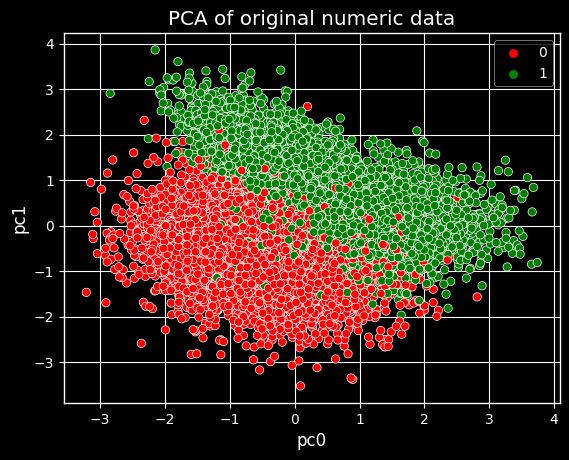

In [ ]:
# 8.1 PCA plot from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA of original numeric data');


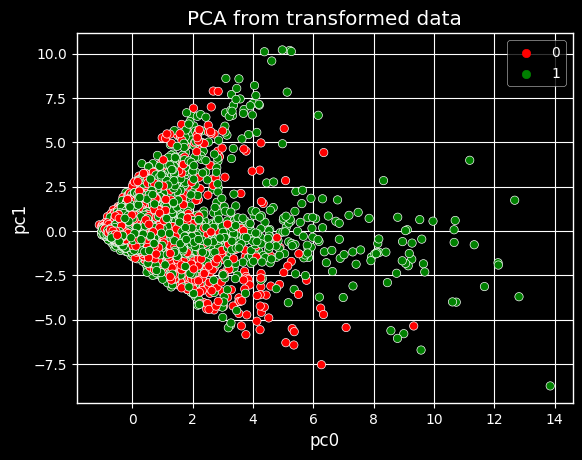

In [ ]:
# 8.2 PCA plot from transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data') ;

## xgboost modeling:
With all features

In [ ]:
# 9.0 Original train/test data:

model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,      
                               max_depth = 6,
                               subsample = 0.8, 
                               random_state = None,
                              )

# 9.0.1
tr_X =   orig_train
test_X = orig_test
ytr = ytr 
yte = yte 

# 9.0.2
model_orig.fit(tr_X, ytr.values,             
               early_stopping_rounds = 70,   
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)], 
               eval_metric = ['auc']        
              )



[12:12:21] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[12:12:21] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[12:12:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.98272	validation_1-auc:0.97865
[12:12:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.98609	validation_1-auc:0.98380
[12:12:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.98660	validation_1-auc:0.98527
[12:12:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.98917	validation_1-auc:0.98707
[12:12:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.98981	validation_1-auc:0.98797
[12:12:22] 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 0.9951485148514851'

'Best iteration from orig train/test data: 96'

In [ ]:
# 9.2 Modeling with transformed train/test data:

model_trans = xgb.XGBClassifier( n_estimators= 350,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 14,
                           subsample = 0.8,        
                           evals_result = evals_result,
                           random_state = None,
                           )

# 9.21
tr_X =   train_trans.iloc[:,5:]
test_X = test_trans.iloc[:,5:]
ytr = ytr 
yte = yte 

# 9.22
model_trans.fit(tr_X, ytr.values,     
          early_stopping_rounds = 60, 
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[12:13:15] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[12:13:15] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[12:13:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 662 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.98111	validation_1-auc:0.96235
[12:13:17] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.98591	validation_1-auc:0.97046
[12:13:17] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.98882	validation_1-auc:0.97747
[12:13:18] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 550 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.98962	validation_1-auc:0.97922
[12:13:18] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=14
[4]	validation_0-auc:0.99106	validation_1-auc:0.98062
[12:1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=None, num_parallel_tree=None, ...)

### Learning curve plots

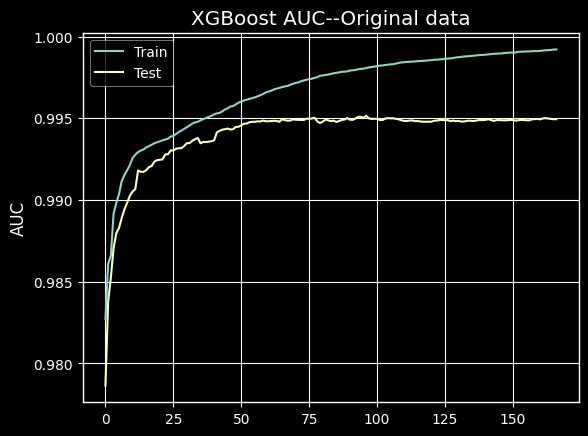

In [ ]:
# 9.3 Learning curve of modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Original data');
plt.show();

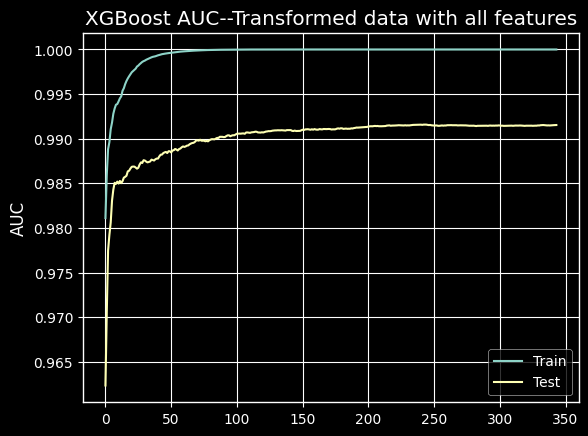

In [ ]:
# 9.4 Learning curve of model with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, np.round(results['validation_0']['auc'],2), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],2), label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Transformed data with all features');
plt.show();

In [ ]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.9915831583158315'

'Best iteration from transformed train/test data: 243'

## Feature importance of transformed data
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::  
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>  

In [ ]:
# 10.0 Get feature importance:
#      fe: Sorted Pandas DataFrame with column name and top-down feature impt 

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]     # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
eig_i_ck_f_p_h,0.161122
clu_i_ck_f,0.141725
eig_i_ck_e,0.046374
pr_i_ck_e,0.029434
eig_g_ck_e_p_h,0.021075




== Column-list whose feat impt >0 =======



['eig_i_ck_f_p_h', 'clu_i_ck_f', 'eig_i_ck_e', 'pr_i_ck_e', 'eig_g_ck_e_p_h']



===Column-list whose feat impt is 0 =======



['clu_e_ck_h', 'pr_e_ck_h', 'eig_e_ck_h', 'bet_e_ck_h', 'clu_h_ck_e']

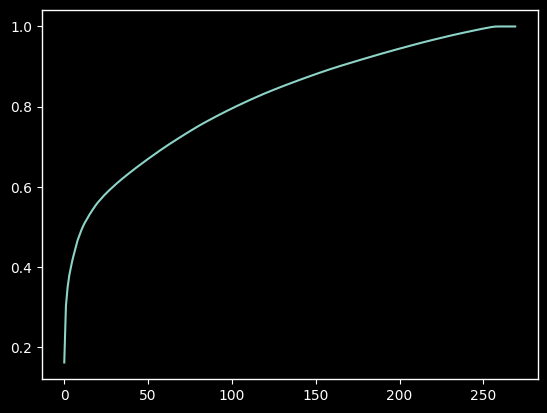

In [ ]:
# 10.1 Cumulative sum of feature importance.
#      Last 100 columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

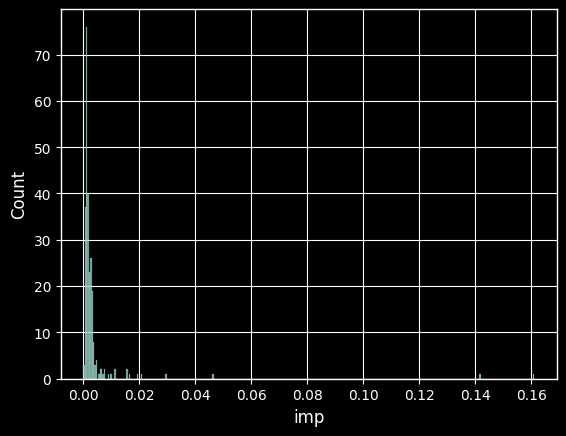

In [ ]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt much below 0.01

sns.histplot(fe['imp'][fe_1]);

### XGBoost modeling with impt features

In [ ]:
# 11.0 Modeling of transformed train/test data with impt features:

model_trans_impt = xgb.XGBClassifier( n_estimators= 300,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 14,
                           subsample = 0.8,        
                           random_state = None,
                           )

# 11.0.1
tr_X =   train_trans[fe_1[:100]]
test_X = test_trans[fe_1[:100]]
ytr = ytr 
yte = yte 


# 11.0.2
model_trans_impt.fit(tr_X, ytr.values,     
          early_stopping_rounds = 80, 
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[12:18:12] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[12:18:12] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[12:18:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 624 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.98141	validation_1-auc:0.97080
[12:18:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 494 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.98614	validation_1-auc:0.97482
[12:18:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.98753	validation_1-auc:0.97836
[12:18:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.98854	validation_1-auc:0.98028
[12:18:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 548 extra nodes, 0 pruned nodes, max_depth=14
[4]	validation_0-auc:0.98969	validation_1-auc:0.98136
[12:1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 11.1 Learning curve: Modeling with transformed data:
#      We get results better than with all features:

results = model_trans[fe_1[:100]].evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Transformed data but with impt features');
plt.show();

TypeError: ignored

## PCA with original data and transformed data:
While performing PCA, we only use impt features

In [ ]:
# 12.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(18000, 2)

In [ ]:
# 12.1 PCA with transformed train data.
#      We keep just the impt features

trans_pca = train_trans[fe_1[:100]] #.iloc[:,len(cat_cols):]  
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

(18000, 2)

In [ ]:
# 12.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

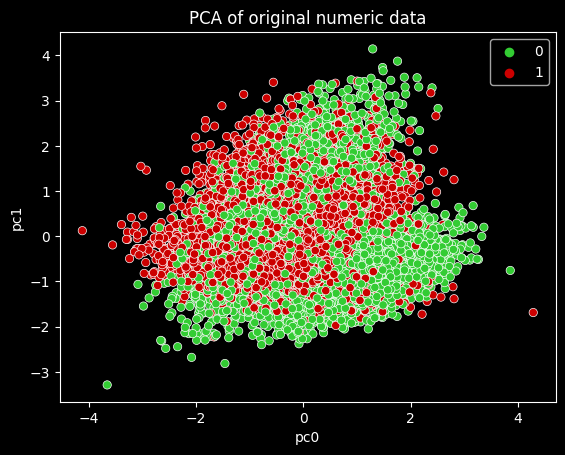

In [ ]:
# 12.3 PCA plot from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA of original numeric data');


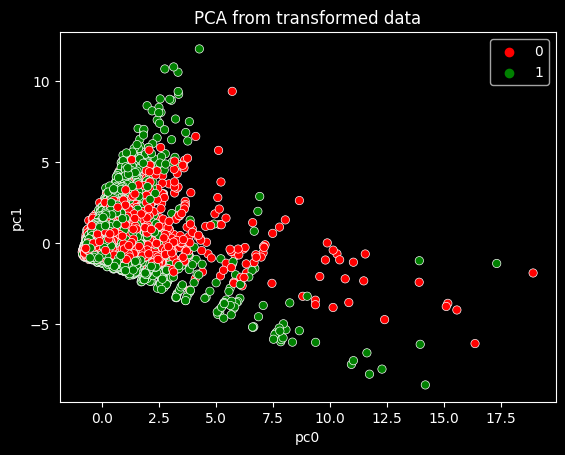

In [ ]:
# 12.4 PCA plot from transformed data but with impt features:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data') ;


## Correlation with orig columns
Correlation of extracted features with original features

In [ ]:
# 13.0 Take top five imp features:

tt = train_trans[fe_1[:5]].copy()
tt.shape  # (9000,341)

(18000, 5)

In [ ]:
# 13.1 Reindex orig_train and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows some amount of correlation between the two sets of features

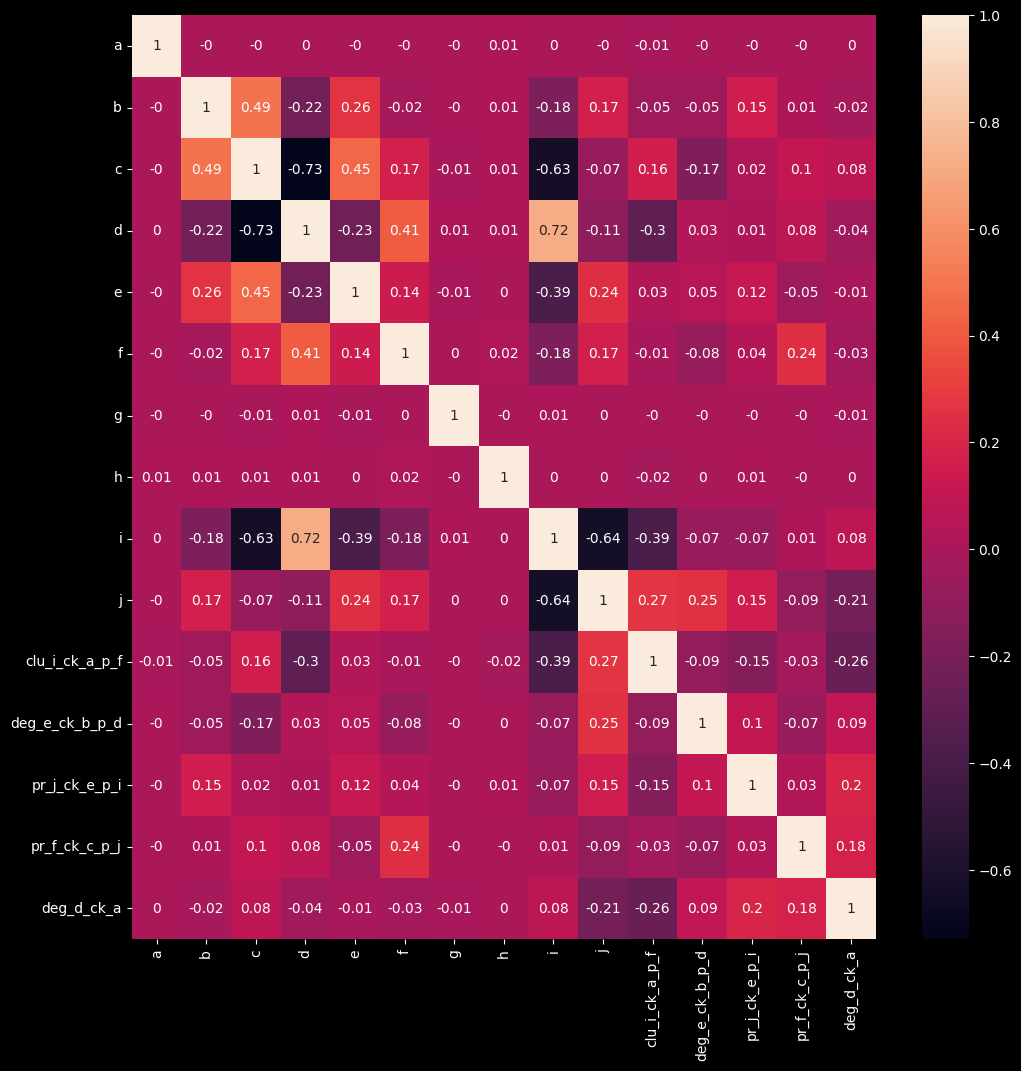

In [ ]:
# 13.2 Correlation heatmap:

plt.figure(figsize = (12,12))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

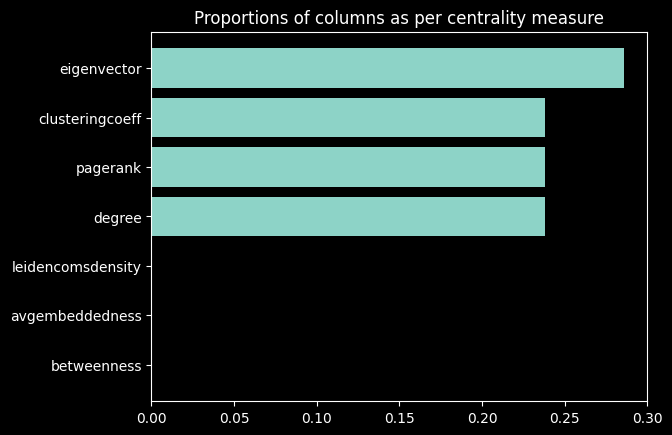

In [ ]:
# 14.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [ ]:
# 14.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 98'

'Columns whose impt is 0: 2'

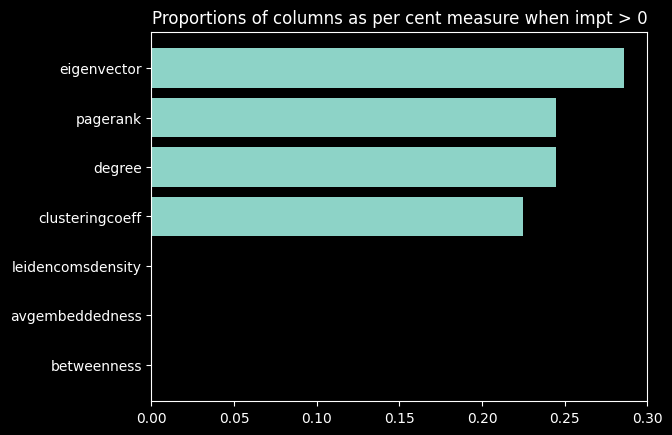

In [ ]:
# 14.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [ ]:
# 15.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [ ]:
# 15.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 15.2 Score of all impt columns:
score

deg_a_ck_c        0.053653
eig_a_ck_c        0.043786
deg_a_ck_b        0.042709
clu_a_ck_c        0.040359
pr_a_ck_j         0.024897
                    ...   
clu_a_ck_d_p_e    0.003424
clu_a_ck_b_p_g    0.003348
clu_a_ck_g_p_j    0.003262
clu_a_ck_i_p_j    0.002682
deg_a_ck_g_p_i    0.002025
Name: imp, Length: 98, dtype: float32

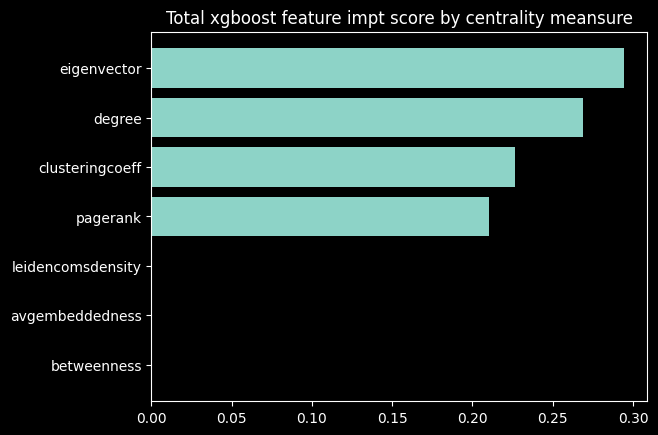

In [ ]:
# 15.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_classif



In [ ]:
mi_scores = utils.calMIScores(train_trans[colList], ytr)
mi_scores[::3]  # show a few features with their MI scores

eig_area_mean_ck_concavity_worst_p_concavity_mean       0.411510
eig_area_mean_ck_area_mean_p_area_se                    0.398181
eig_area_mean_ck_area_mean_p_texture_mean               0.396951
eig_area_mean_ck_area_se_p_concavity_worst              0.388818
eig_area_mean_ck_area_mean_p_concavity_worst            0.386731
                                                          ...   
deg_texture_mean_ck_concavity_worst_p_concavity_mean    0.048080
eig_area_se_ck_concavity_worst                          0.043185
deg_texture_mean_ck_area_mean_p_concavity_worst         0.032534
bet_texture_mean_ck_area_se                             0.011870
pr_texture_mean_ck_area_se                              0.000000
Name: MI Scores, Length: 90, dtype: float64

In [ ]:
fe.cumsum()
len(fe)